A very quick look at the evolving coronavirus cases in LA County, starting with Jan 21st, when the first case got diagnosed in the county. Data comes from the LA County Public Health website:
http://publichealth.lacounty.gov/media/Coronavirus/
I am updating the data as it comes in. 

            confirmed cases  deaths  hospitalized
date                                             
2020-01-22                0       0             0
2020-01-23                0       0             0
2020-01-24                0       0             0
2020-01-25                0       0             0
2020-01-26                1       0             0


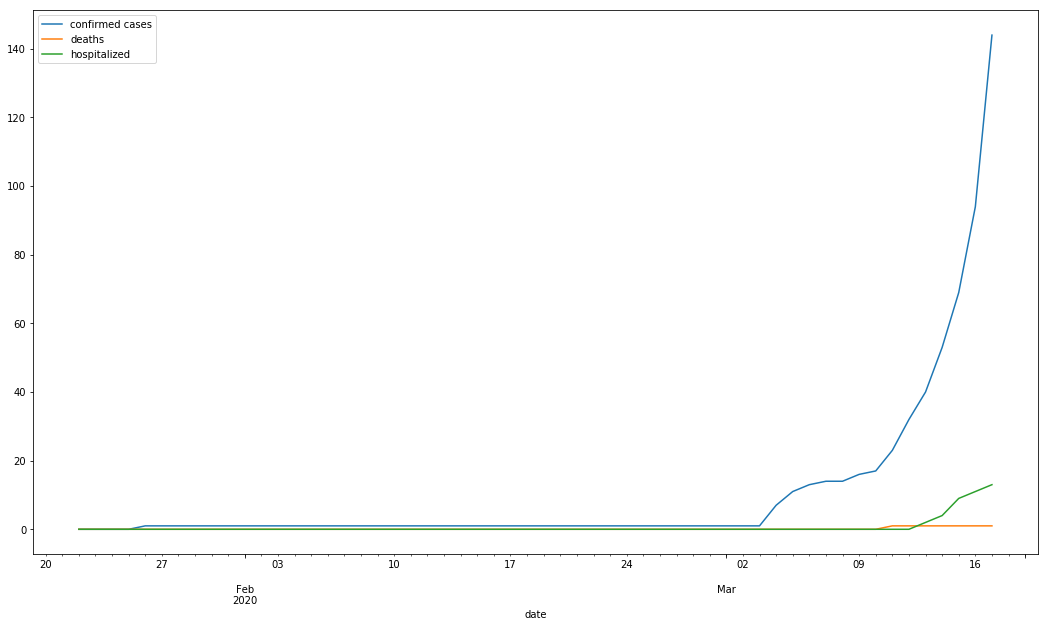

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('LACountyCovid.csv', header=0, index_col=0, squeeze=True)
df.index = pd.to_datetime(df.index)
df.index.name = 'date'
print(df.head())

df.plot(figsize=(18,10))
plt.show()
